This section will detail the preprocessing and EDA portion of the report. This will lead us up to the training of two separate models, Resnet18 and EfficientNet.

First we import all required libraries. We assume all libraries have been previously installed.

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
from typing import List
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns

c:\Users\billy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Below we have downloaded the dataset and observe all folders where our data is located.

In [3]:
# Download latest version of the dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print(os.listdir(path))

train_df_path =  os.path.join(path, "Train.csv")
test_df_path =  os.path.join(path, "Test.csv")

train_img_path =  os.path.join(path, "Train")
test_img_path =  os.path.join(path, "Test")

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


In [5]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


Just from this snippet, evident that images will vary in pixel size (see width and height column). This issue will be tackled later. The "Roi" columns reflect the upper left and lower right pixels coordinates of the sign in the image, whilst ClassId simply classifies the type of sign. 

For meaningful EDA to be conducted, we create a new variable that transforms the ClassId column to be more descriptive of the observation. 

In [6]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,ClassName
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Single curve right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Single curve right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Single curve right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Single curve right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Single curve right


In [7]:
train_df['ClassName'].value_counts()

ClassName
Speed Limit (50Km/hr)                           2250
Speed Limit (30Km/hr)                           2220
Yeild right of way                              2160
Priotity Road                                   2100
Keep right                                      2070
No Passing for trucks over 3.5 tons             2010
Speed Limit (70Km/hr)                           1980
Speed Limit (80Km/hr)                           1860
Construction side ahead                         1500
No Passing                                      1470
Speed Limit (100Km/hr)                          1440
Speed Limit (60Km/hr)                           1410
Speed Limit (120Km/hr)                          1410
Right of way                                    1320
Mandatory direction of travel ahead             1200
Danger                                          1200
Entery prohibited                               1110
Stop                                             780
Wild animal crossing                

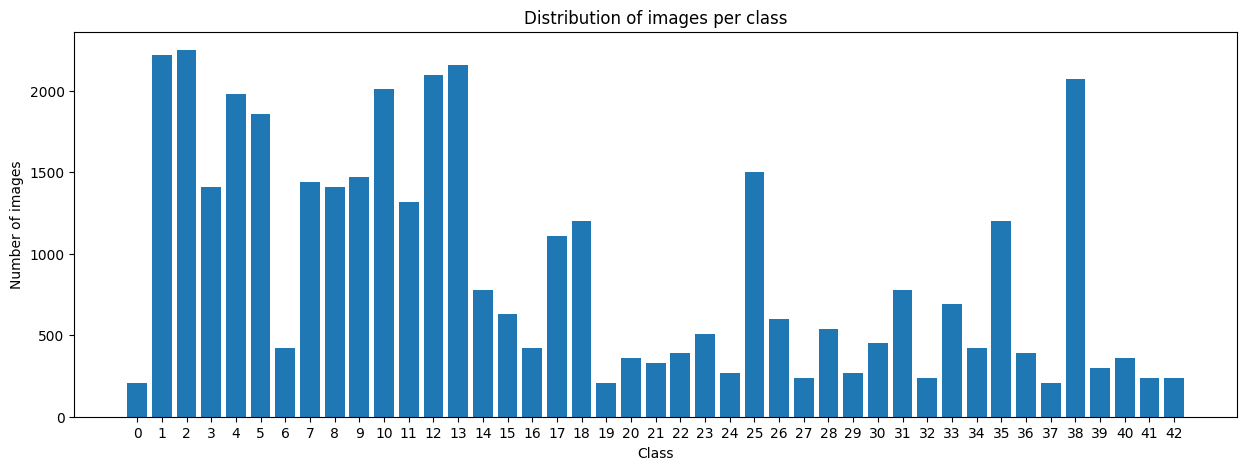

In [10]:
counts = train_df['ClassId'].value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("Distribution of images per class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(counts.index)
plt.show()

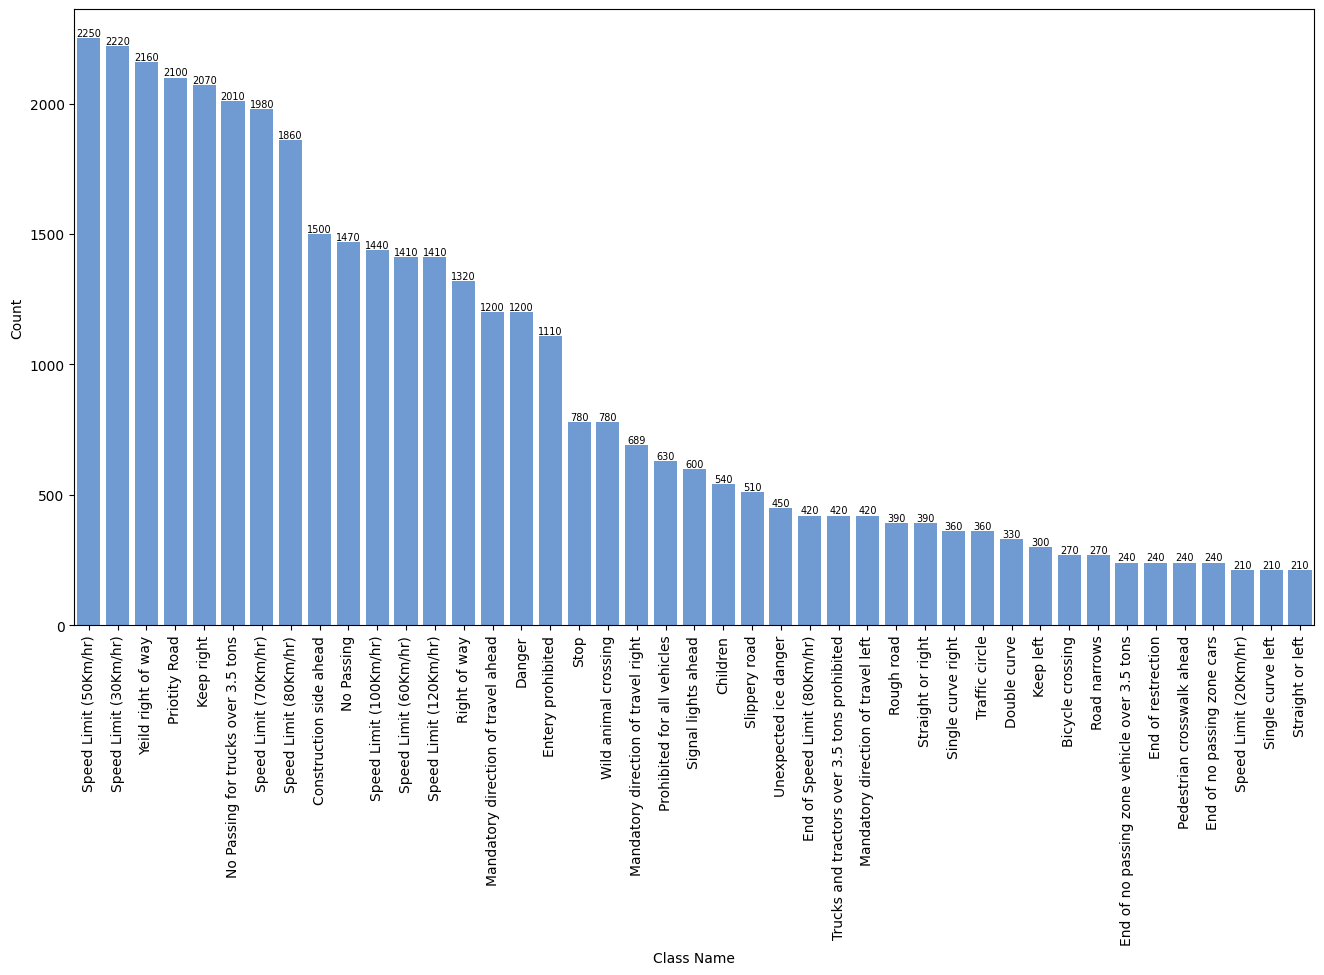

In [11]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#5F98E2")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()

In [12]:
print(f"Maximum images per class: {train_df['ClassName'].value_counts().max()} (Class: {train_df['ClassName'].value_counts().idxmax()})")
print(f"Minimum images per class: {train_df['ClassName'].value_counts().min()} (Class: {train_df['ClassName'].value_counts().idxmin()})")
print(f"Average images per class: {train_df['ClassName'].value_counts().mean():.1f}")

Maximum images per class: 2250 (Class: Speed Limit (50Km/hr))
Minimum images per class: 210 (Class: Speed Limit (20Km/hr))
Average images per class: 911.8


In [13]:
def random_image_generator(class_id):
    if class_id < 0 or class_id > 42:
        raise ValueError("class_id must be between 0 and 42 inclusive.")

    folder = os.path.join(train_img_path, str(class_id))
    image_files = [f for f in os.listdir(folder) if not f.startswith(".")]

    filename = random.choice(image_files)
    sample_path = os.path.join(folder, filename)

    img = Image.open(sample_path)

    return img

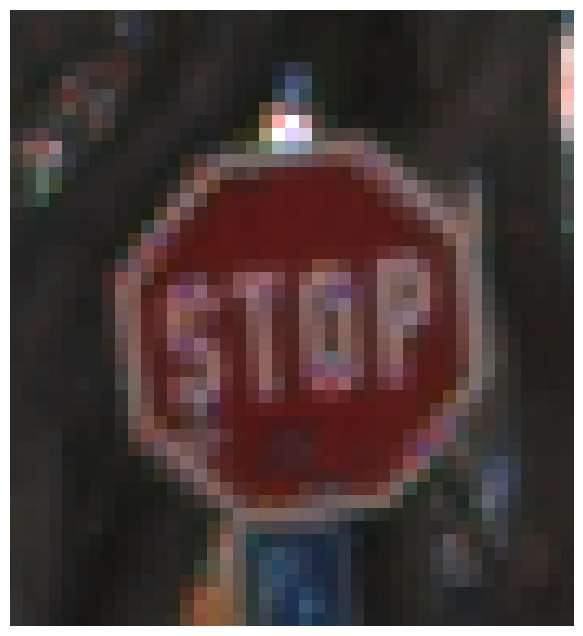

In [89]:
random_class = random.randint(0, 42)
img1 = random_image_generator(random_class)

plt.figure(figsize=(8,8))
plt.imshow(img1)
plt.axis("off")
plt.show()

In [90]:
def get_image_paths(filepath: str) -> Tuple[List[str], List[str]]:
    image_paths = []
    class_labels = []

    for root, _, files in os.walk(filepath):
        for filename in files:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".ppm", ".bmp")):
                full_path = os.path.join(root, filename)
                image_paths.append(full_path)

                # grab class folder name
                class_id = os.path.basename(root)
                class_labels.append(class_id)

    return image_paths, class_labels

train_image_paths, train_labels = get_image_paths(train_img_path)

In [91]:
def print_sample_images(n, cols):
    total = len(train_image_paths)
    num_images = min(n*cols, total)

    if num_images >= total:
        print("WARNING: Total images exceed available images. Returning all available images. This may take a while.")

    if (n, cols) >= (100, 5):
        print("WARNING: You are attempting to plot many images. This may take a while.")

    plt.figure(figsize=(cols*3, n*3))

    for i, k in enumerate(random.sample(range(total), num_images), start=1):
        img = plt.imread(train_image_paths[k])
        plt.subplot(n, cols, i)
        plt.imshow(img)
        plt.title(class_names[int(train_labels[k])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

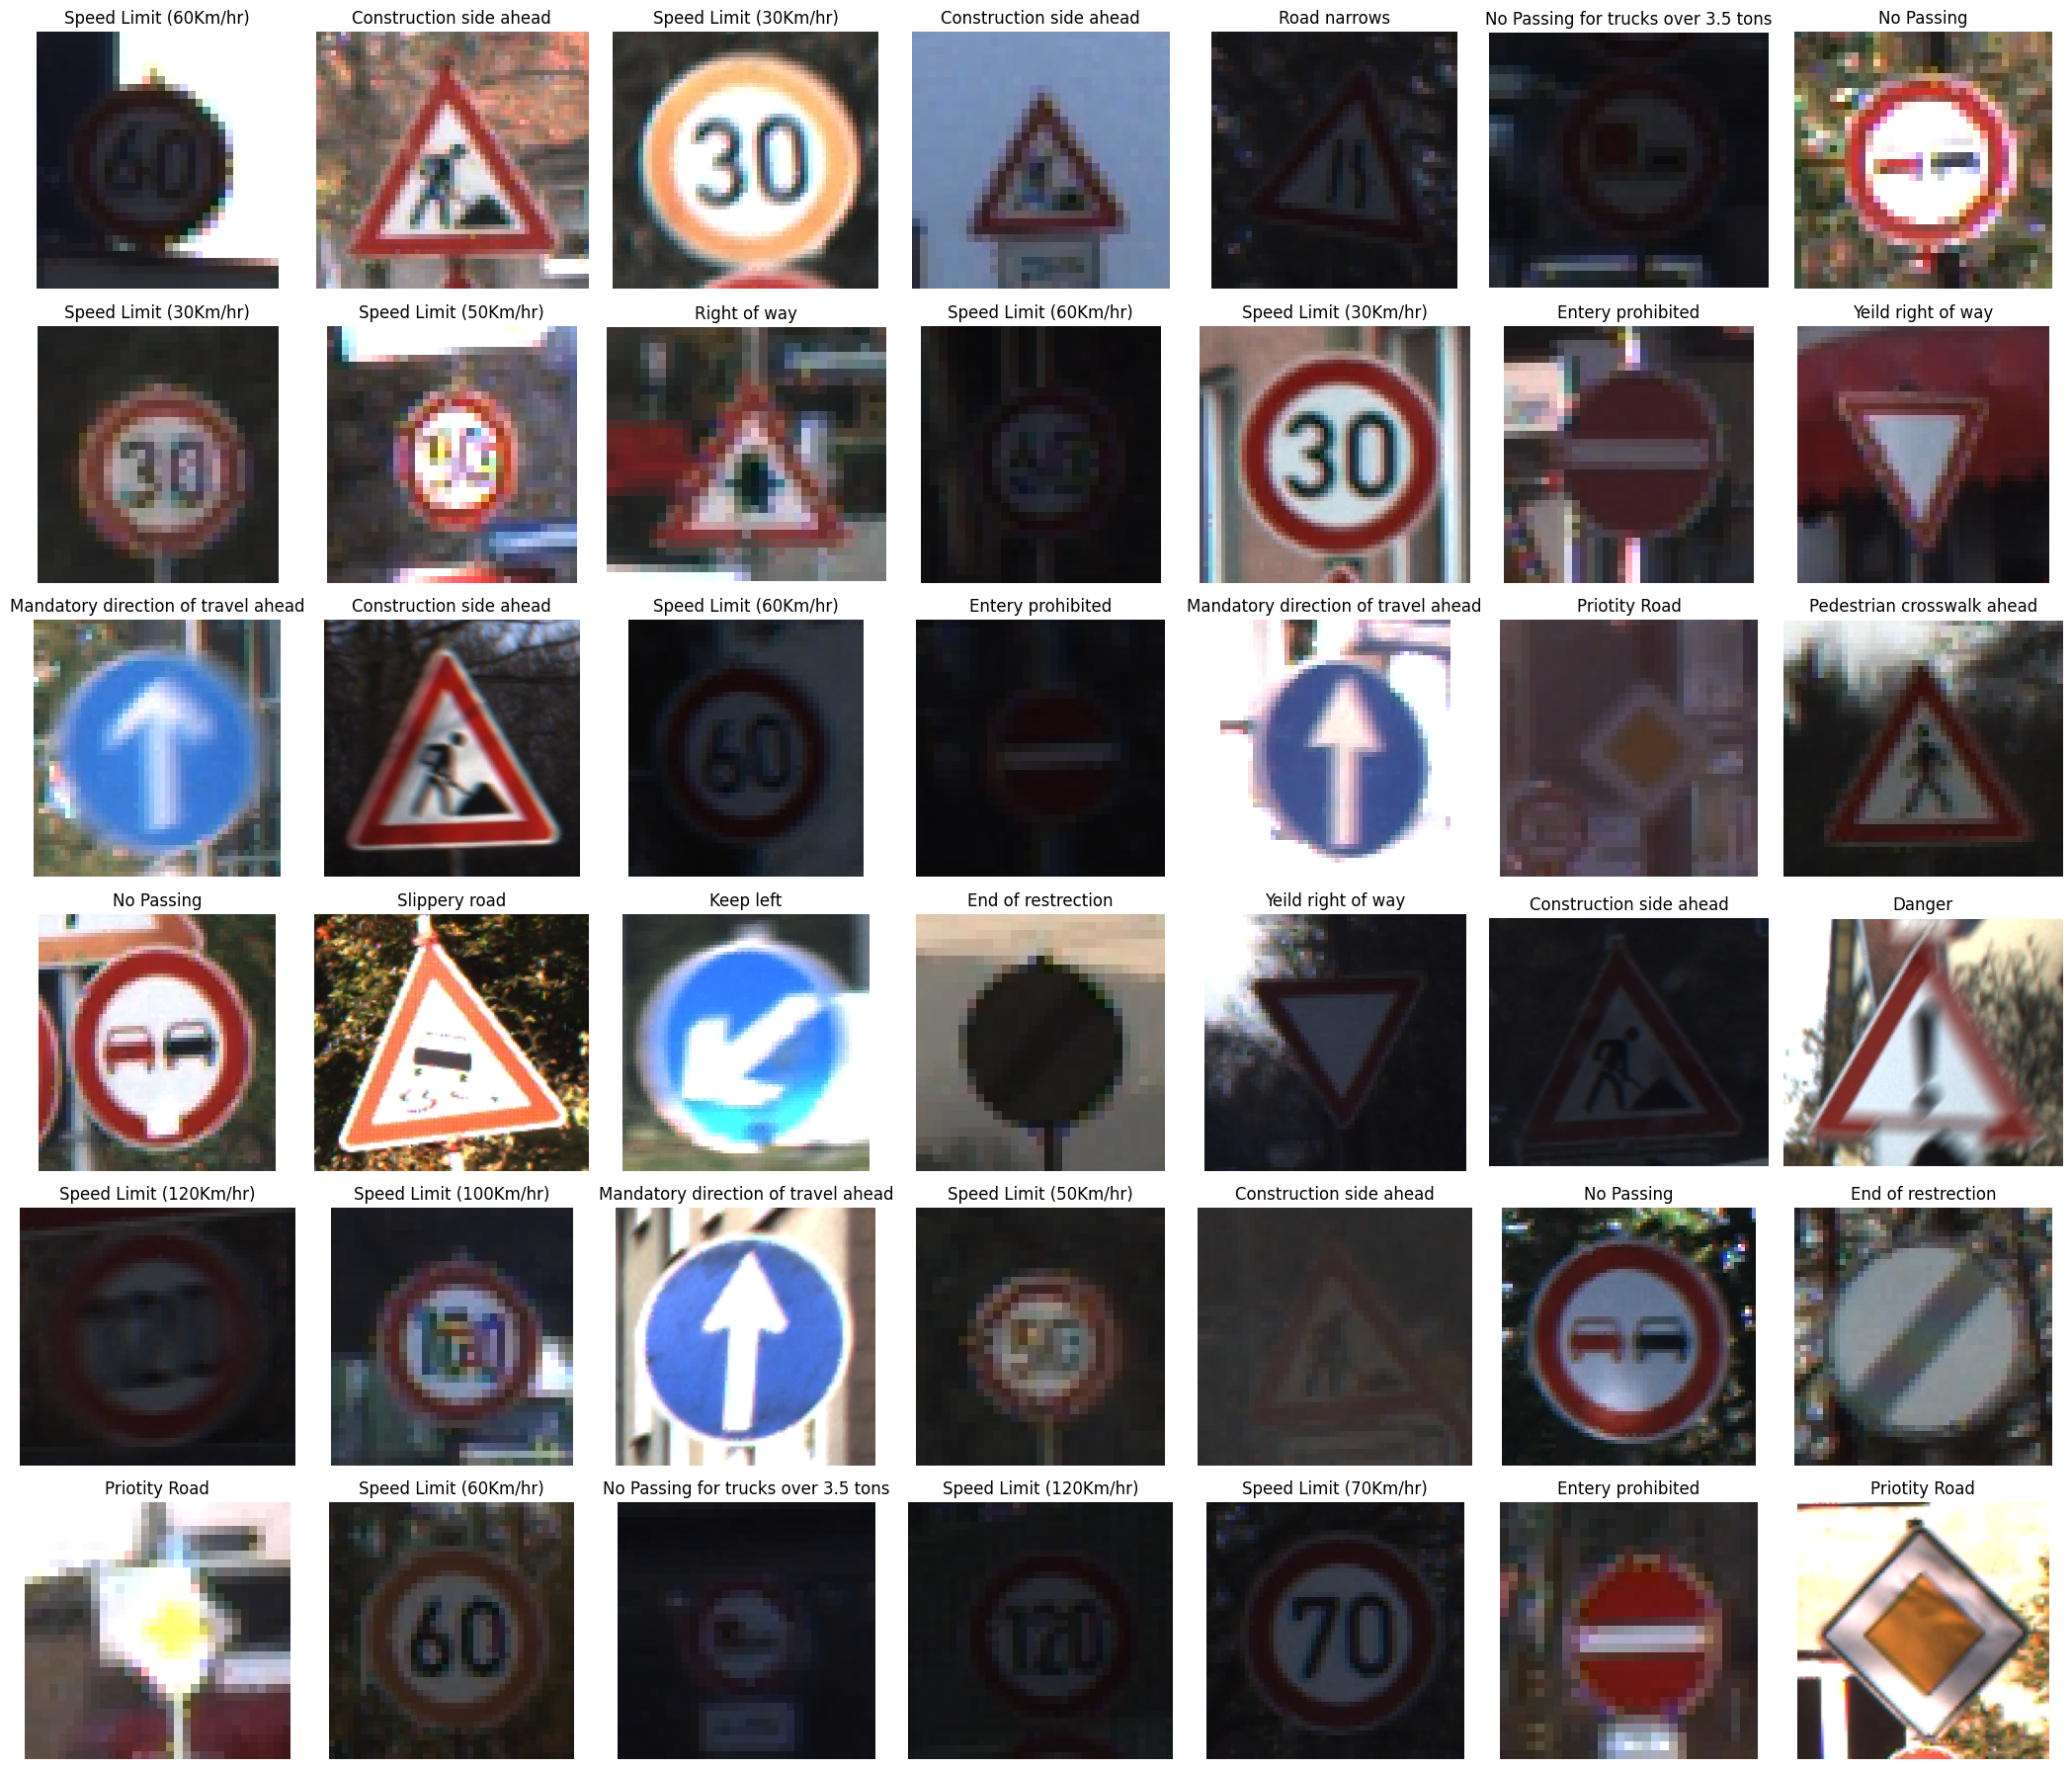

In [92]:
print_sample_images(6,7)